# Portfolio Analysis of Consumer staples sector

### Stocks under observation:

    - PepsiCo (NASDAQ:PEP) 
    - Procter & Gamble (NYSE:PG)
    - Unilever (NYSE:UL)
    - Walmart (NYSE:WMT)
    - Coca-Cola (NYSE:KO)
    - Costco Wholesale (NASDAQ:COST)


In [34]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as wb
import scipy.optimize as sco
import warnings

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Pulling stock data 

In [35]:
staples = ['PEP', 'PG', 'UL', 'WMT','KO', 'COST' ]
data = pd.DataFrame()
for i in range(len(staples)):
    
    df = wb.DataReader(staples[i], data_source='yahoo', start='2019-1-1', end = '2020-1-1')
    df['stock'] = staples[i]
    data = data.append(df[['Adj Close', 'stock']])

table = data.pivot(columns='stock')
# By specifying col[1] in below list comprehension
# You can select the stock names under multi-level column
table.columns = [col[1] for col in table.columns]
table.head()

,COST,KO,PEP,PG,UL,WMT
Date,,,,,,
2019-01-02,201.880554,45.093166,105.419327,87.674057,49.719532,90.685211
2019-01-03,197.601593,44.814518,104.435371,87.059349,49.490540,90.218872
2019-01-04,203.339752,45.708115,106.576935,88.836266,50.301544,90.782379
2019-01-07,204.089035,45.112381,105.660500,88.480881,49.929436,91.851089
2019-01-08,205.617264,45.621643,106.673393,88.807457,49.938972,92.492317


Text(0, 0.5, 'price in $')

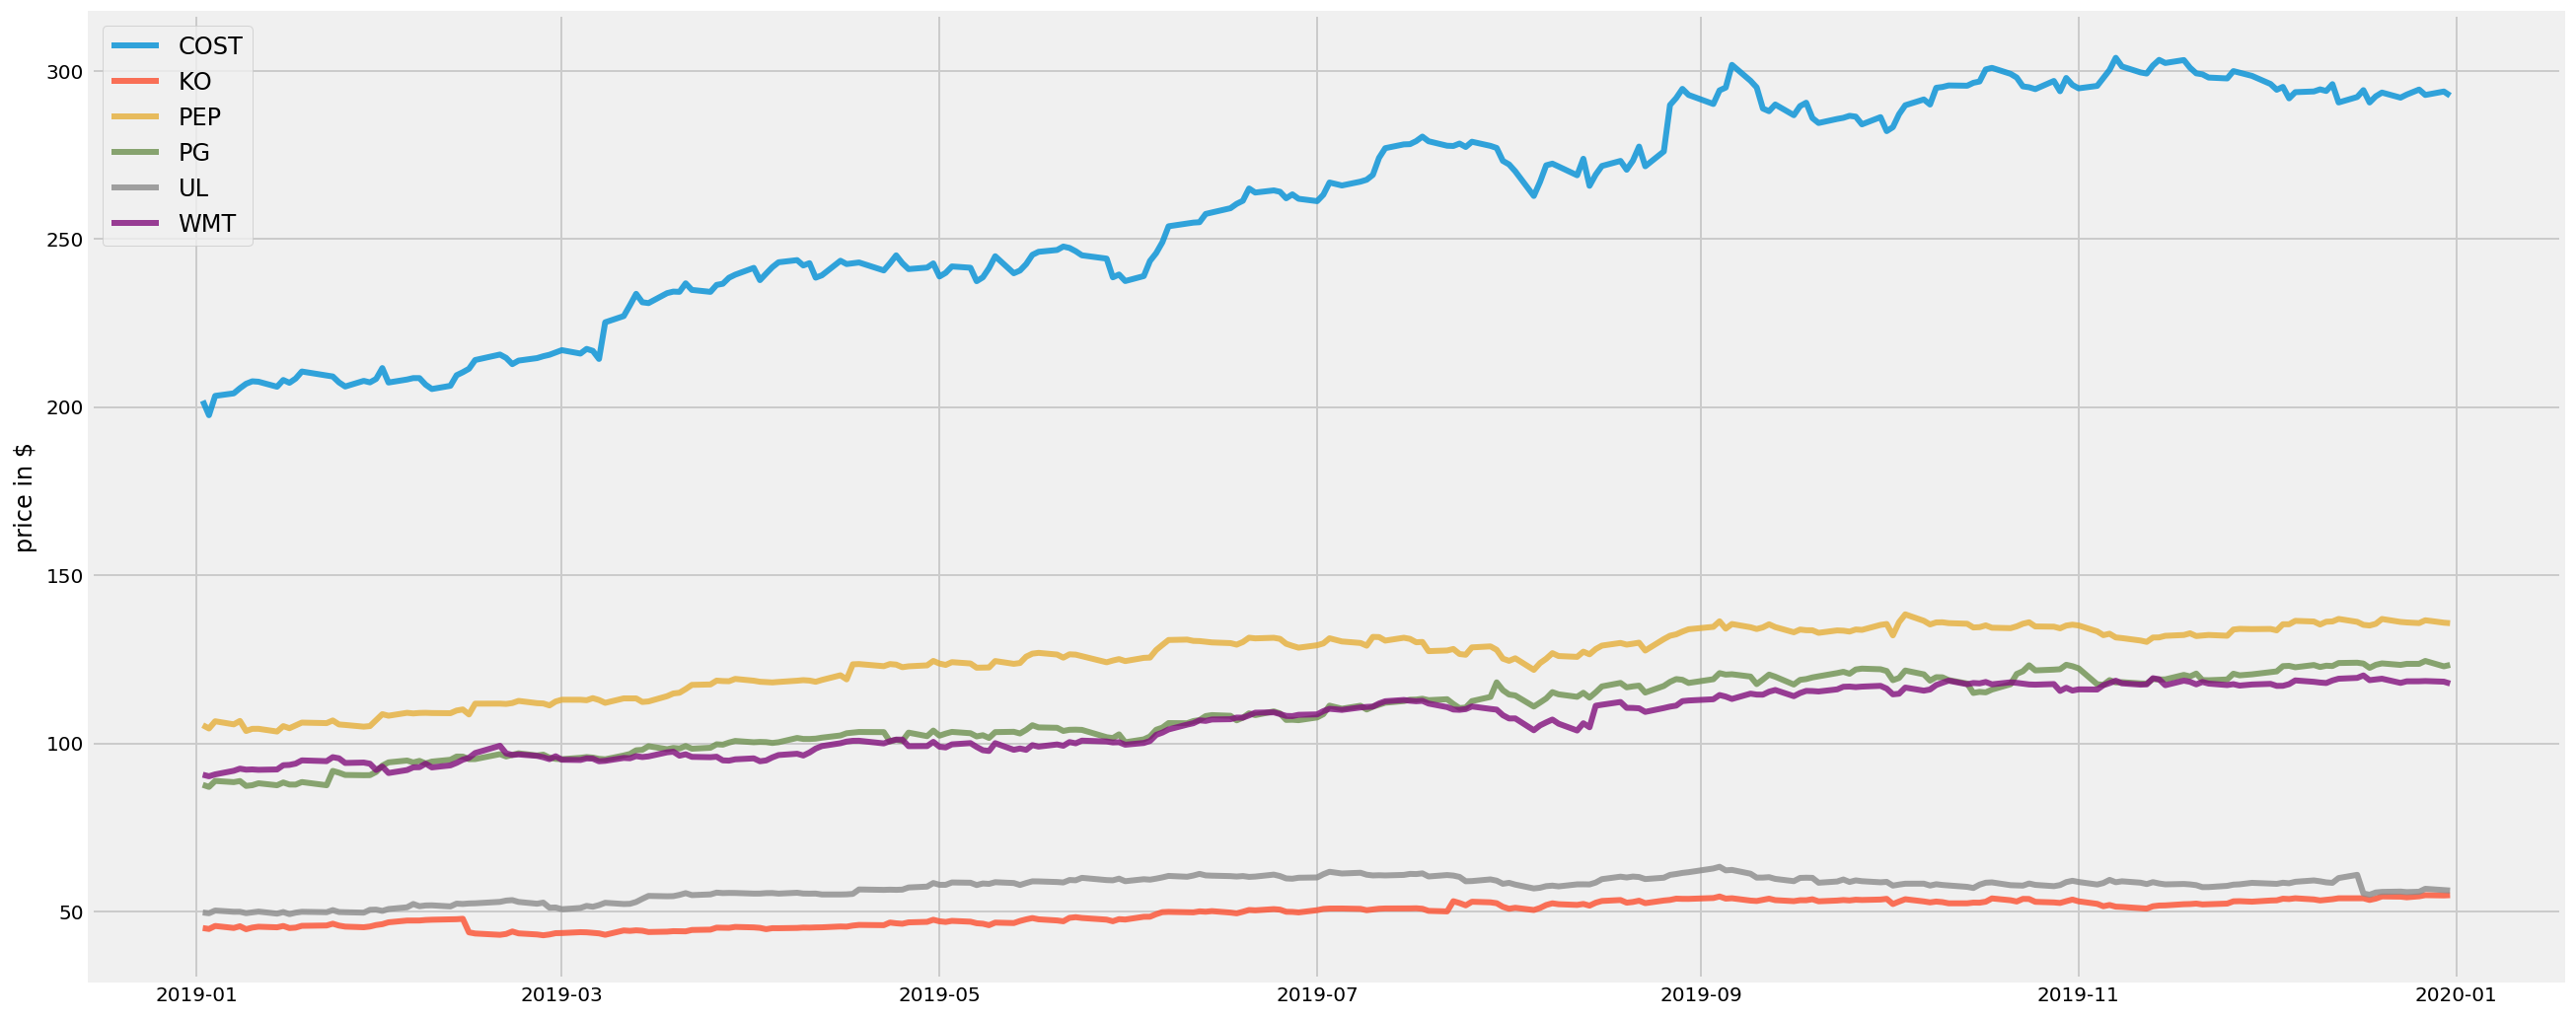

In [36]:
plt.figure(figsize=(20, 9))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

### Simple returns

Text(0, 0.5, 'daily returns')

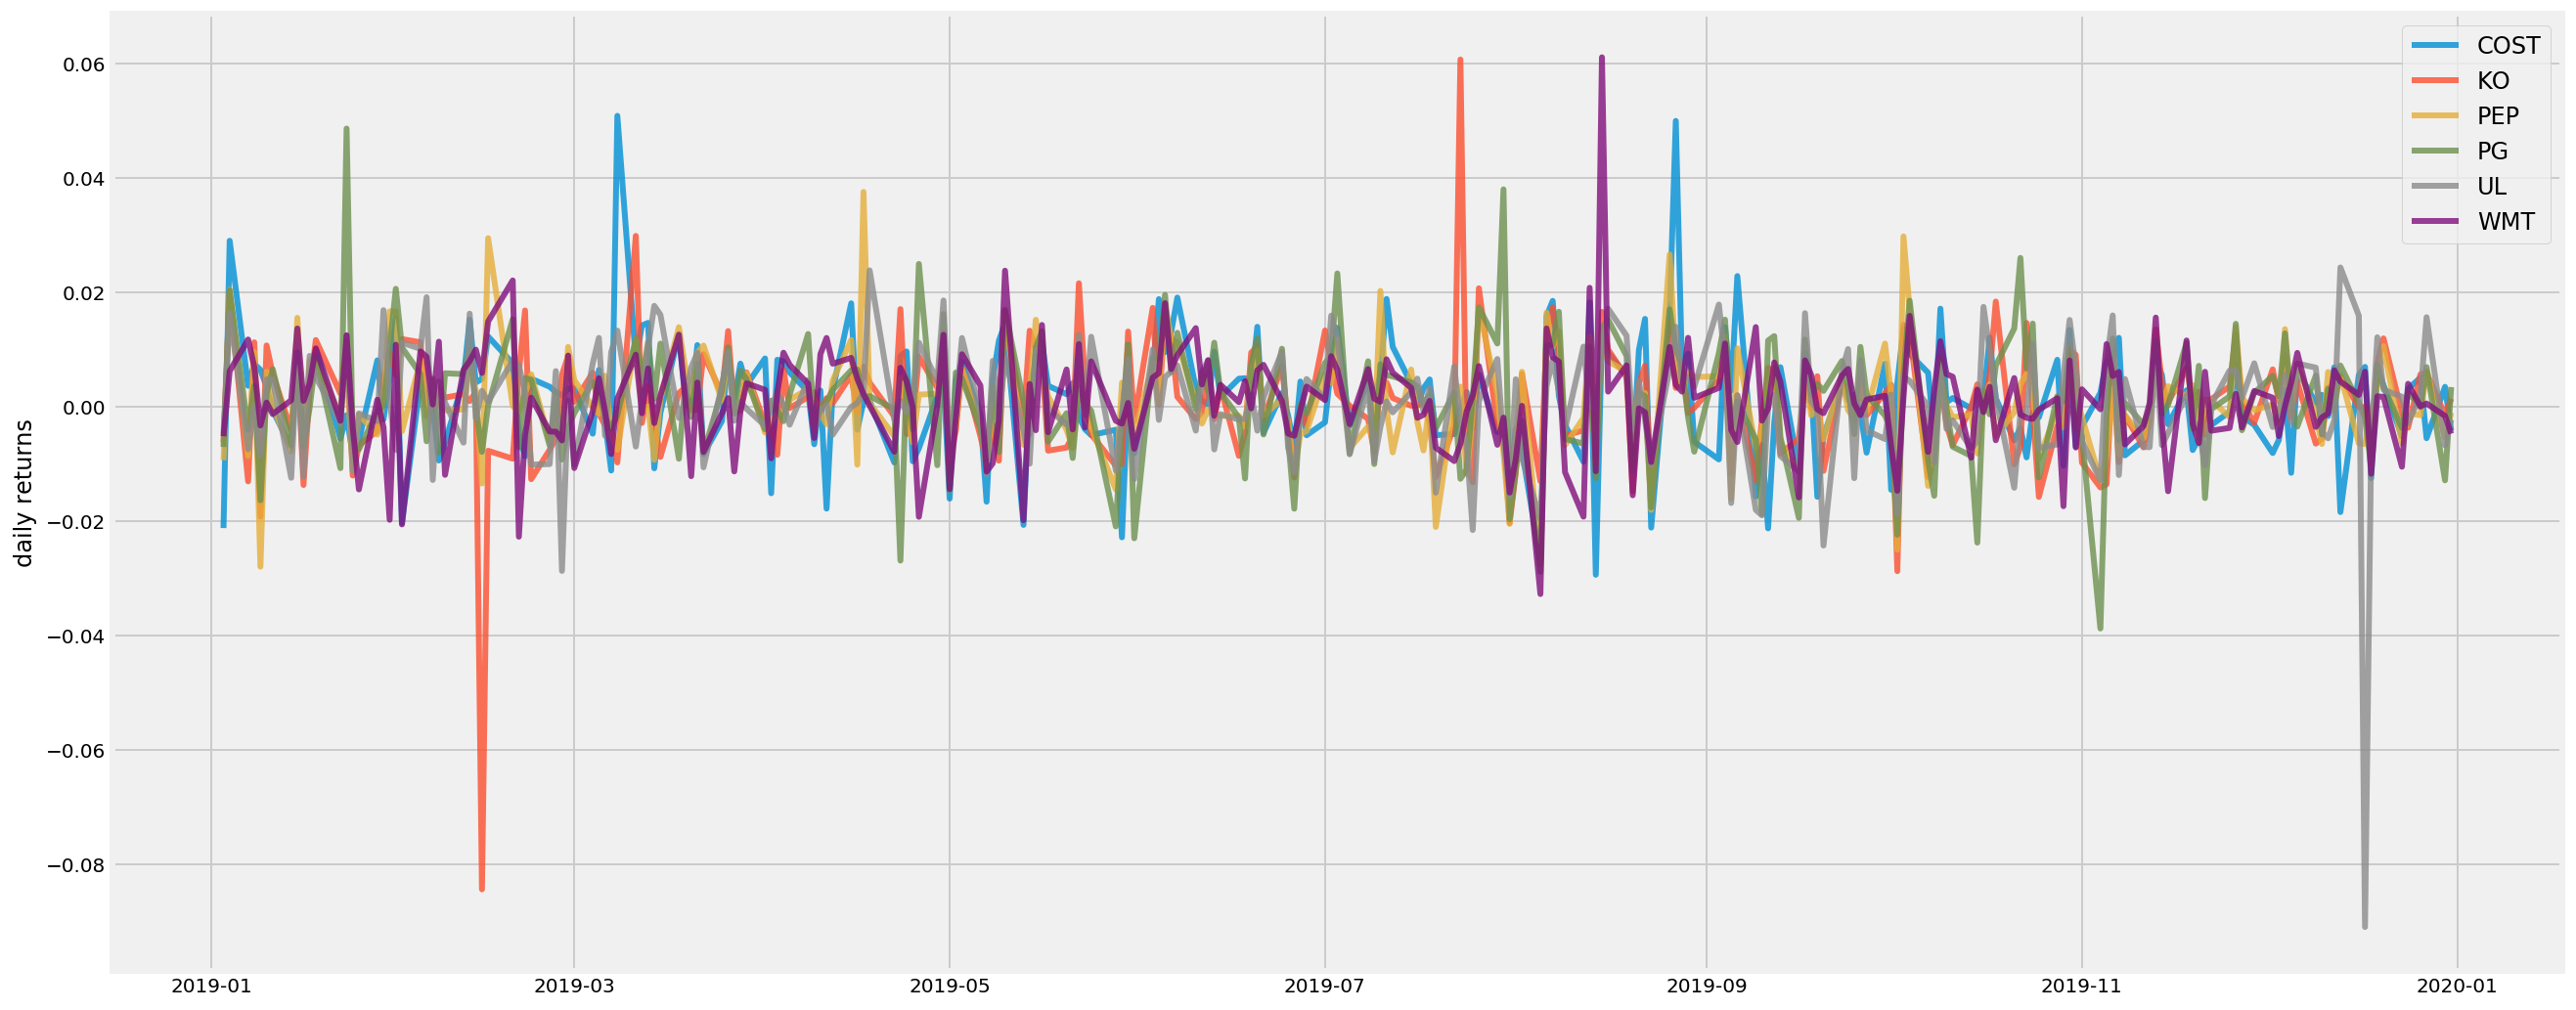

In [37]:
returns = table.pct_change()
plt.figure(figsize=(20, 9))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

### log returns

Text(0, 0.5, 'daily log returns')

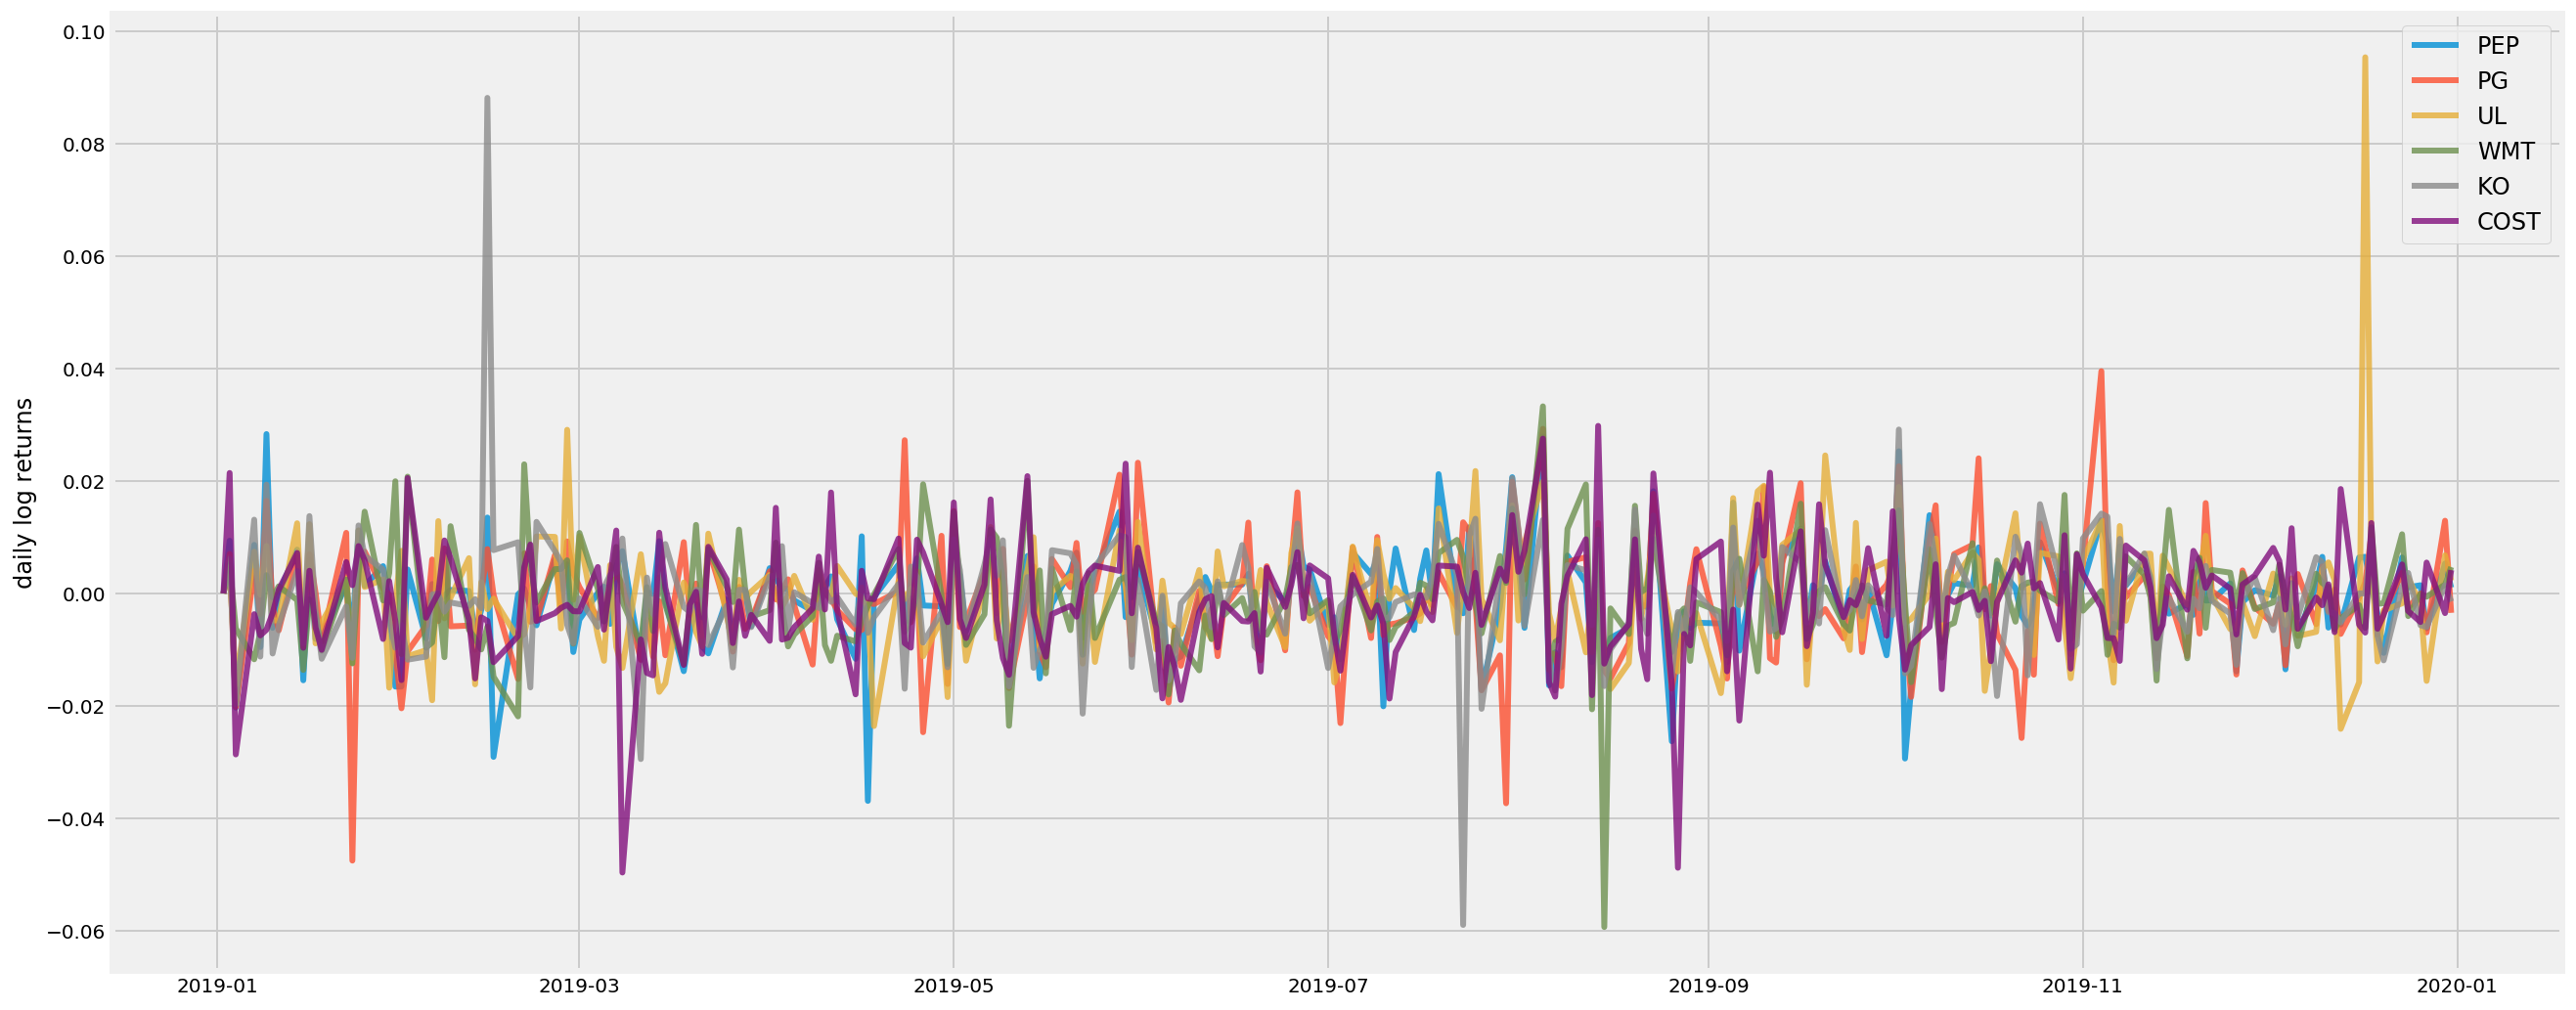

In [38]:
log = pd.DataFrame(columns = staples, index = table.index)

for i in range(len(staples)):
    log_list = []
    for j in range(len(table[staples[i]])):
        if(j+1<len(table[staples[i]])):
            log_returns =  np.log(table[staples[i]][j]) - np.log(table[staples[i]][j+1])
            log_list.append(log_returns)
            

        else:
            None
    log_list.insert(0, 0)   
    log[staples[i]] = log_list


plt.figure(figsize=(20, 9))
for c in log.columns.values:
     plt.plot(log.index, log[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily log returns')


### Normalization to 100

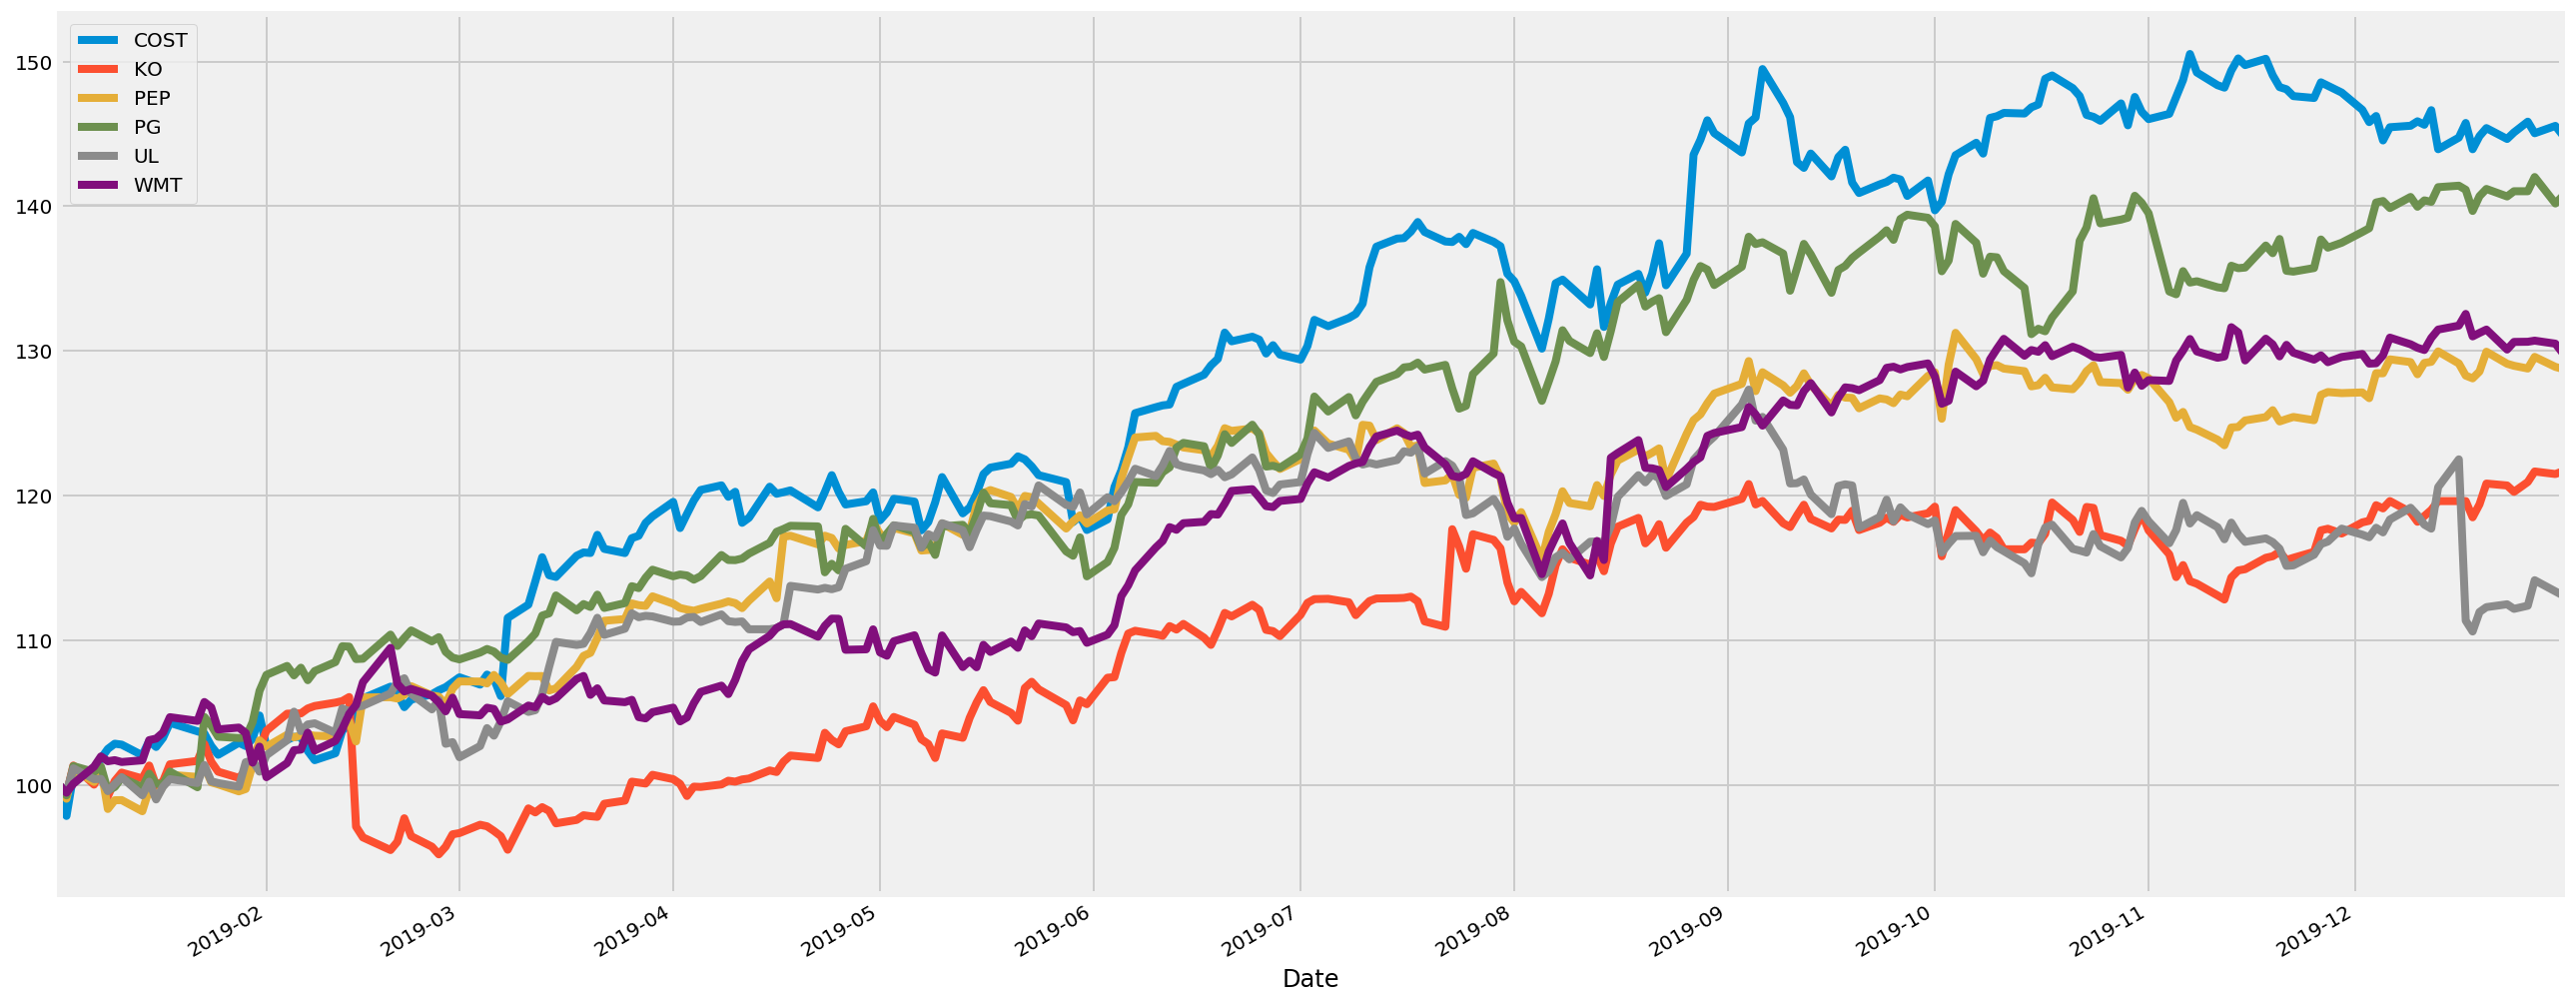

In [39]:
(table/table.iloc[0] * 100).plot(figsize = (20,9))
plt.show()

In [40]:
returns

,COST,KO,PEP,PG,UL,WMT
Date,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,-0.021196,-0.006179,-0.009334,-0.007011,-0.004606,-0.005142
2019-01-04,0.029039,0.019940,0.020506,0.020410,0.016387,0.006246
2019-01-07,0.003685,-0.013033,-0.008599,-0.004000,-0.007398,0.011772
2019-01-08,0.007488,0.011289,0.009586,0.003691,0.000191,0.006981
...,...,...,...,...,...,...
2019-12-24,0.003137,-0.003642,-0.001095,0.002562,-0.002814,0.004033
2019-12-26,0.005098,0.005666,-0.001461,0.000000,0.001940,0.000084
2019-12-27,-0.005478,0.005998,0.006218,0.006948,0.015669,0.000586


In [41]:
log.mean()*252

PEP    -0.252894
PG     -0.341318
UL     -0.123437
WMT    -0.261580
KO     -0.196214
COST   -0.371243
dtype: float64

In [42]:
log.std()*252**0.5

PEP     0.138306
PG      0.164416
UL      0.170161
WMT     0.143115
KO      0.170924
COST    0.159993
dtype: float64

In [43]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(6)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return(results, weights_record)

mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 50000
risk_free_rate = 0.02

def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print( "Maximum Sharpe Ratio Portfolio Allocation\n")
    print( "Annualised Return:", round(rp,2))
    print( "Annualised Volatility:", round(sdp,2))
    print( "\n")
    print( max_sharpe_allocation)
    print( "-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print( "Annualised Volatility:", round(sdp_min,2))
    print( "\n")
    print( min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.34
Annualised Volatility: 0.12


             COST   KO    PEP     PG   UL    WMT
allocation  37.14  1.0  12.85  33.69  0.2  15.11
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.26
Annualised Volatility: 0.11


            COST     KO    PEP    PG     UL    WMT
allocation  19.0  14.38  14.99  4.57  20.01  27.05


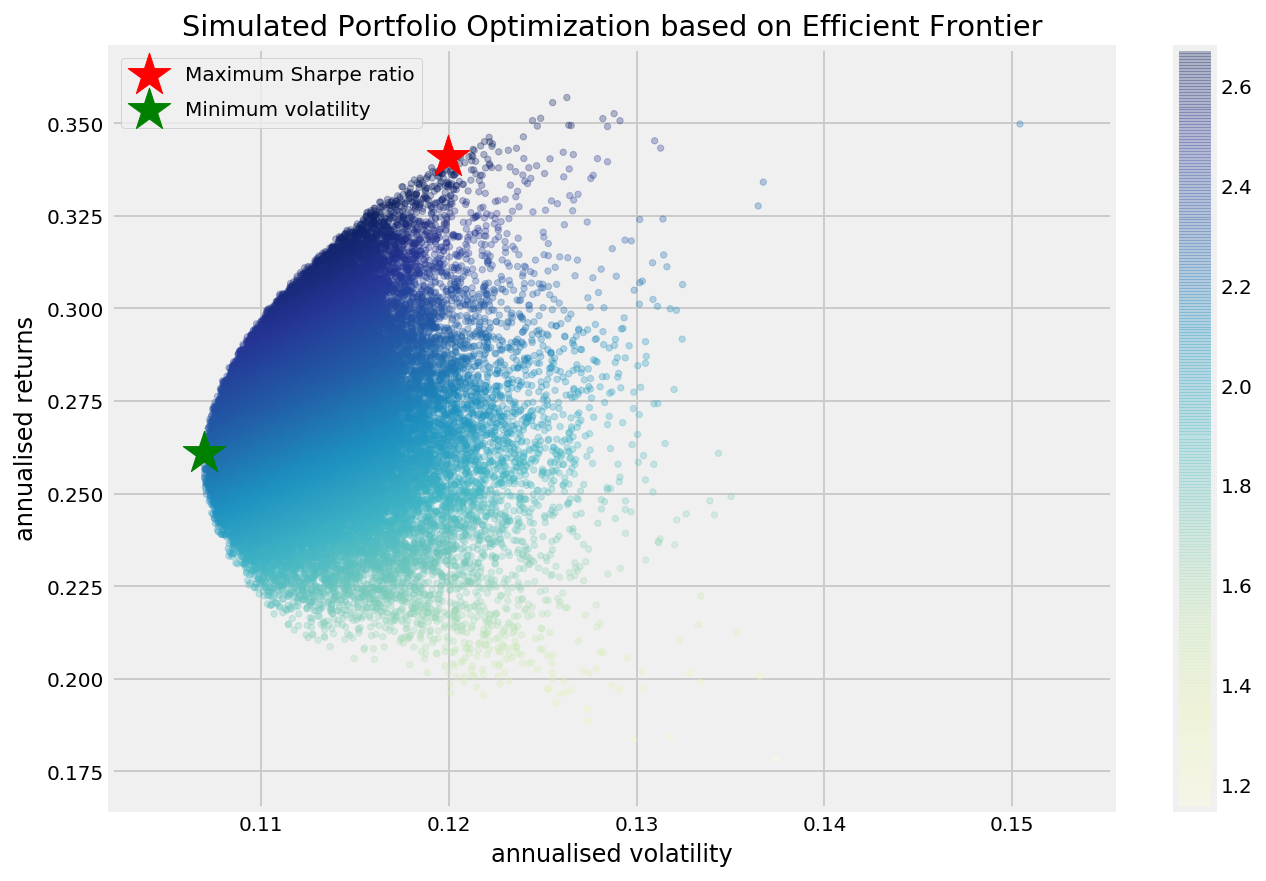

In [44]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)